In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('dark_background')

# Exercise 1: Direct PCA method

## a,b) Covarience matrix and displaying

In [2]:
def get_covariance_matrix(in_points):
    mu = np.zeros(2)
    mu[0] = np.mean(in_points[:, 0]) #np.sum(in_points[:, 0]) / in_points.shape[0]
    mu[1] = np.mean(in_points[:, 1])
    centered = in_points - mu
    covariance = (1 / (in_points.shape[0] - 1)) * centered.T @ centered
    return mu, covariance

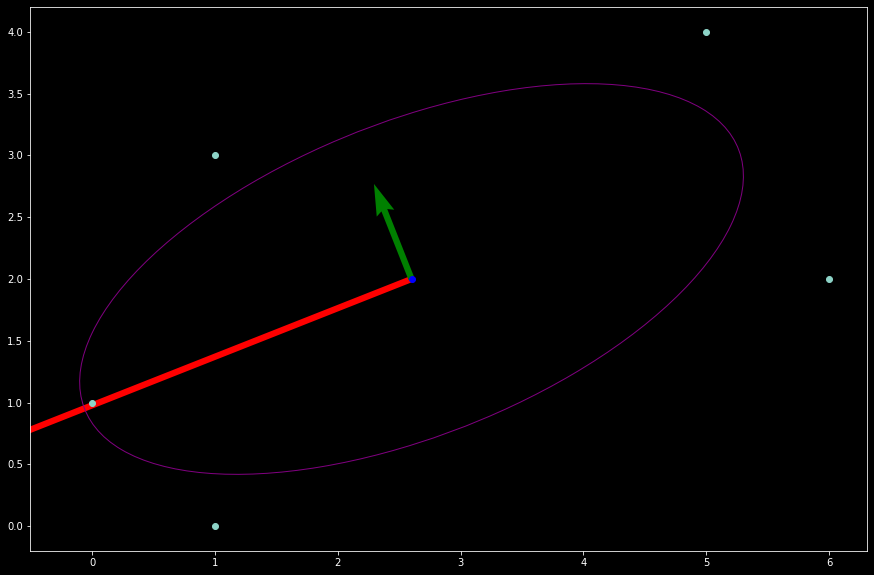

In [3]:
from a6_utils import drawEllipse

points = np.loadtxt('data/points.txt')
points_mean, points_c = get_covariance_matrix(points)
points_U, points_S, _ = np.linalg.svd(points_c)

plt.figure(figsize=(15, 10))
plt.quiver(points_mean[0], points_mean[1], points_U[0, 0], points_U[1, 0], scale=points_S[1], color='red')
plt.quiver(points_mean[0], points_mean[1], points_U[0, 1], points_U[1, 1], scale=points_S[0], color='green')
plt.scatter(points_mean[0], points_mean[1], color='blue')
plt.scatter(points[:,0], points[:,1])
drawEllipse(points_mean, points_c)
plt.show()

## c) Cumulative graph

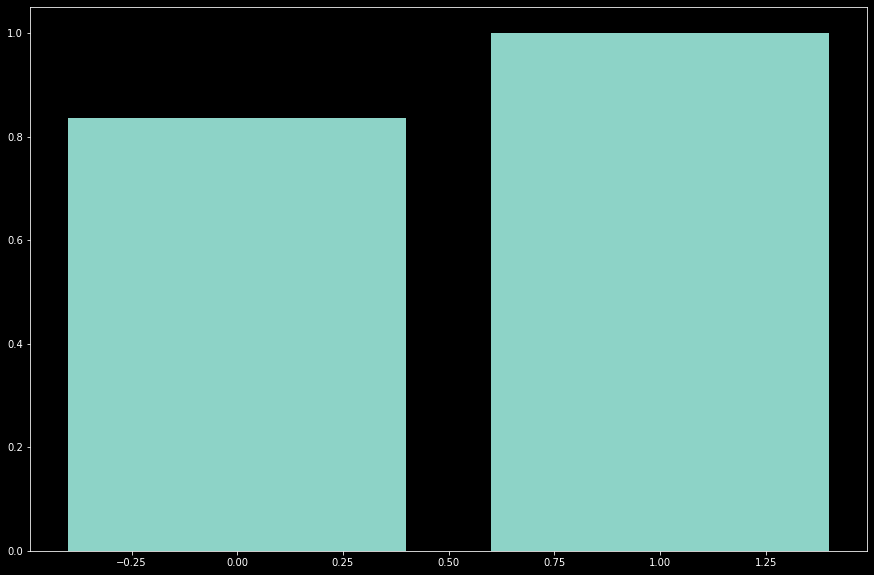

In [4]:
plt.figure(figsize=(15,10))
plt.bar([0, 1], np.cumsum(points_S/np.sum(points_S)))
plt.show()

## d) Single vector subspace

In [10]:
class PCA:
    def __init__(self, points):
        self.mu, self.C = get_covariance_matrix(points)
        self.U, _, _ = np.linalg.svd(self.C)
    
    def project(self, point):
        return self.U.T @ (point - self.mu)

    def project_arr(self, points):
        pts = np.copy(points)
        for i, p in enumerate(points):
            pts[i] = self.project(p)
        return pts

    
    def project_back(self, point):
        return (self.U @ point) + self.mu

    def project_back_arr(self, points):
        pts = np.copy(points)
        for i, p in enumerate(points):
            pts[i] = self.project_back(p)
        return pts
    
    def project_back_subspace(self, points, i): # removes vector[:, i]
        temp_U = np.copy(self.U)
        temp_U[:, i] = 0
        pts = np.copy(points)
        for i, p in enumerate(points):
            pts[i] = (temp_U @ p) + self.mu
        return pts

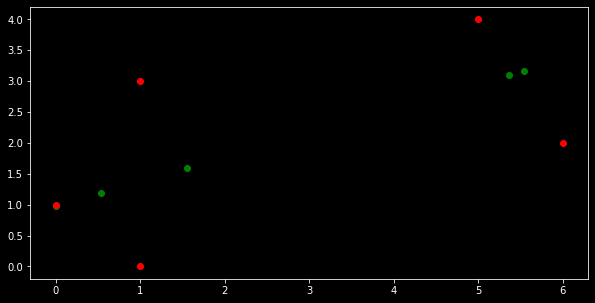

In [13]:
pca = PCA(points)
pcad_points = pca.project_back_subspace(pca.project_arr(points), 1)
plt.figure(figsize=(10,5))
plt.scatter(pcad_points[:,0], pcad_points[:,1], color='green')
plt.scatter(points[:,0], points[:,1], color='red')
plt.show()

## e) Distance

In [7]:
def shortestDistance(pts, pt):
    dist_min = -1
    dist_ind = 0
    for i, p in enumerate(pts):
        dist = np.linalg.norm(p - pt)
        if i == 0 or dist < dist_min:
            dist_min = dist
            dist_ind = i
    return dist_ind

Euclid: points[2]: [5. 4.]
PCA:    pca_e_points[2]: [5.35938577 3.09119215]


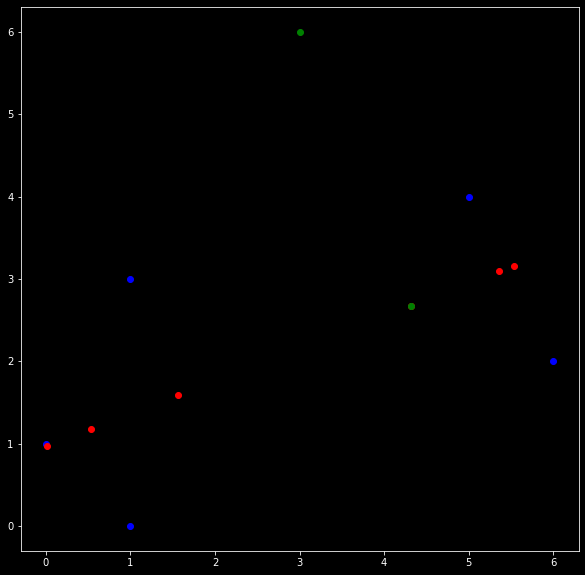

In [17]:
# euclid
qpt = [3, 6]
short_ind = shortestDistance(points, qpt)
print(f"Euclid: points[{short_ind}]: {points[short_ind]}")

# pca_space
pcae_points = np.vstack([pcad_points, pca.project_back_subspace([pca.project(qpt)], 1)])
short_ind = shortestDistance(pcae_points[:5], pcae_points[5])
print(f"PCA:    pca_e_points[{short_ind}]: {pcae_points[short_ind]}")

# draw
plt.figure(figsize=(10, 10))
plt.scatter(points[:,0], points[:,1], color='blue')
plt.scatter(pcae_points[:,0], pcae_points[:,1], color='red')
plt.scatter(pcae_points[5,0], pcae_points[5,1], color='green')
plt.scatter(qpt[0], qpt[1], color='green')
plt.show()

# Exercise 2: The dual PCA method

## a) Dual PCA

In [37]:
class DualPCA:
    def __init__(self, points):
        self.mu = np.mean(points, axis=0)
        centered = points - self.mu
        self.C = (1 / (points.shape[1] - 1)) * centered @ centered.T

        self.U, self.S, _ = np.linalg.svd(self.C)
        self.U = (centered.T @ self.U) @ np.sqrt(np.linalg.inv(np.diag(self.S) * (points.shape[1] - 1)))
    
    def project(self, point):
        return self.U.T @ (point - self.mu)

    def project_arr(self, points):
        pts = np.copy(points)
        for i, p in enumerate(points):
            pts[i] = self.project(p)
        return pts

    def project_back(self, point):
        return (self.U @ point) + self.mu

    def project_back_arr(self, points):
        pts = np.copy(points)
        for i, p in enumerate(points):
            pts[i] = self.project_back(p)
        return pts

In [38]:
np.set_printoptions(suppress=True)
dual_pca = DualPCA(points)
print(dual_pca.U)

[[ 0.92992935 -0.36773822 -0.00000002  0.00000001 -0.00000002]
 [ 0.36773822  0.92992935  0.         -0.00000002  0.        ]]


## b) Dual PCA example

In [27]:
def test_dualPCA(in_points, mean, U):
    points = np.copy(in_points)
    points = U.T @ (points - mean).T
    points = (U @ points).T + mean

    return points

In [30]:
print(points)
print(test_dualPCA(points, dual_pca.mu, dual_pca.U))

[[1. 0.]
 [6. 2.]
 [5. 4.]
 [1. 3.]
 [0. 1.]]
[[ 1.  0.]
 [ 6.  2.]
 [ 5.  4.]
 [ 1.  3.]
 [-0.  1.]]


# Exercise 3: Image decomposition example

## a) Data preparation

In [42]:
def prepare_imgs(path):
	ret = []
	x = True
	for f in os.listdir(path):
		ret.append(cv2.cvtColor(cv2.imread(path + f), cv2.COLOR_BGR2GRAY).reshape(-1))

	return np.array(ret)

## b) Using dual PCA

In [43]:
images1_prep = prepare_imgs('data/faces/1/')

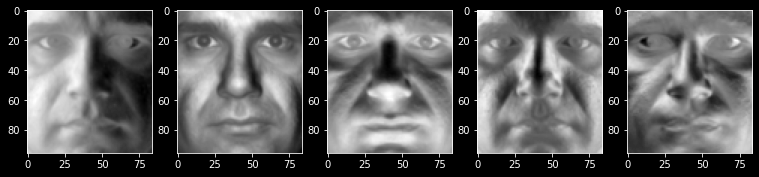

In [47]:
dual_pca_imgs = DualPCA(images1_prep)

plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(dual_pca_imgs.U[:,i].reshape(96, 84), cmap='gray')
plt.show()